# Abusive Language Detection using NLP

**Objective:** Build a text classification pipeline for abusive language detection using classical NLP techniques — BoW, TF-IDF, Naive Bayes, and Logistic Regression.

---

In [1]:
import sys
import subprocess
import importlib
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Auto-install missing packages at runtime (useful in notebooks)
def _ensure_packages(mapping):
    for mod, pkg in mapping.items():
        try:
            importlib.import_module(mod)
        except Exception:
            print(f'Installing {pkg}...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
            try:
                importlib.import_module(mod)
            except Exception as e:
                print(f'Failed to import {mod} after installing {pkg}: {e}')

_REQUIREMENTS = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'nltk': 'nltk',
}
try:
    _ensure_packages(_REQUIREMENTS)
except Exception as e:
    print('Package install step had issues:', e)

# NLTK (optional — enhanced pipeline if available)
try:
    import nltk
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    from nltk.corpus import stopwords as nltk_sw
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    STOPWORDS = set(nltk_sw.words('english'))
    lemmatizer = WordNetLemmatizer()
    USE_NLTK = True
    print('NLTK available — full preprocessing pipeline active.')
except Exception:
    STOPWORDS = {'i','me','my','we','our','you','your','he','him','his','she','her',
                 'it','they','them','what','who','this','that','are','was','were',
                 'be','been','have','has','had','do','does','did','will','would',
                 'shall','should','may','might','can','could','a','an','the',
                 'and','but','or','for','so','as','at','by','from','of','on',
                 'to','up','with','is','am','not','no','very','just','also','s','t'}
    USE_NLTK = False
    print('NLTK not found — using built-in stopword list.')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

print('All libraries imported successfully.')

Installing seaborn...
Installing nltk...
NLTK available — full preprocessing pipeline active.
All libraries imported successfully.


---
## Exercise 1: Data Loading & Inspection

In [2]:
# Create custom balanced dataset (100 abusive + 100 non-abusive = 200 samples)

abusive_texts = [
    "You are useless", "Shut up idiot", "You stupid moron", "Get lost loser",
    "You are an absolute disgrace", "Nobody likes you", "You are pathetic",
    "Go away you fool", "You dumb creature", "What an imbecile you are",
    "You are worthless trash", "Stop being so stupid", "You are a complete failure",
    "You make me sick", "You are the worst person ever", "You are brain dead",
    "Shut your mouth", "You are garbage", "Idiot dont talk to me",
    "You are mentally ill", "Drop dead you loser", "You are a waste of space",
    "You are disgusting", "Nobody wants you here", "You are a joke",
    "What a complete moron", "You are an embarrassment", "You are scum",
    "You are a piece of trash", "Shut up you fool", "You are really dumb",
    "Go to hell", "I hate you so much", "You are the worst",
    "You idiot learn something", "You are horrible", "You are a disaster",
    "Stupid people like you ruin everything", "You are absolutely useless",
    "What a failure you are", "You are disgusting and vile", "You filthy liar",
    "You are a selfish pig", "You are nothing but trouble", "Pathetic excuse for a human",
    "You are a toxic person", "I despise you", "You are a terrible human",
    "You fool you ruined everything", "You are beyond stupid",
    "You are a worthless coward", "You are an absolute idiot", "Just shut up already",
    "You are the dumbest person", "What a waste of time you are",
    "You are a complete moron", "You are brain dead seriously", "You are vile scum",
    "Go away nobody likes you", "You are pathetically stupid",
    "You imbecile stop talking", "What an arrogant fool", "You are clueless idiot",
    "You are beyond help", "You trash get out", "You worthless excuse",
    "You loser stay away from me", "You are an absolute disaster",
    "You stupid fool ruined it", "You are mentally incompetent",
    "You horrible beast", "Disgusting behaviour from you", "You are foul",
    "You are repulsive", "Your stupidity is unmatched", "You are a toxic individual",
    "You are revolting", "You are the worst kind of person", "You are a filthy rat",
    "You are utterly useless", "I can not stand you", "You are a lying scumbag",
    "Your kind are all idiots", "You are a nasty piece of work",
    "You are a complete waste", "You absolute imbecile", "Shut up and get out",
    "You are a horrible monster", "You failed at everything",
    "You are a rotten individual", "Your existence is pointless",
    "You are a blundering idiot", "You know nothing you fool",
    "You are incompetent trash", "You deserve nothing", "You are a menace",
    "You are a dim-witted fool", "You are an absolute waste of oxygen",
    "Stop being so pathetically stupid", "You are a brainless moron"
]

non_abusive_texts = [
    "Have a nice day", "Thank you very much", "I appreciate your help",
    "You did a great job", "This is wonderful news", "I love spending time with friends",
    "The weather is beautiful today", "Congratulations on your success",
    "I am so happy for you", "You are such a kind person",
    "Thank you for your support", "I really enjoyed the movie",
    "You look wonderful today", "This meal is delicious", "I am grateful for everything",
    "Have a wonderful weekend", "It was great meeting you", "I hope you feel better soon",
    "You always make me smile", "This is a lovely place",
    "I am so proud of you", "You have done an amazing job",
    "The presentation was excellent", "I learned so much today",
    "Thank you for being there for me", "You are very talented",
    "I really admire your work", "This is such a great opportunity",
    "You handled that very professionally", "I am looking forward to seeing you",
    "Keep up the fantastic work", "Your help means the world to me",
    "I appreciate all your efforts", "You have a lovely smile",
    "The team did wonderfully", "I am so lucky to know you",
    "Your kindness is inspiring", "Today was such a productive day",
    "You always bring joy to others", "I feel so blessed",
    "What a beautiful morning", "You are an inspiration to all of us",
    "I had such a wonderful time", "You make everything better",
    "I appreciate your patience", "You were so helpful today",
    "What a great idea you have", "I thoroughly enjoyed the event",
    "Your advice really helped me", "This is going to be amazing",
    "You are very thoughtful", "I love your positive attitude",
    "Today was a good day", "You are so talented and kind",
    "I really respect your opinion", "You did your best and it shows",
    "I am looking forward to working with you", "Your feedback was very useful",
    "What a cheerful person you are", "I enjoyed our conversation today",
    "You always know the right thing to say", "That is such a creative approach",
    "You have been incredibly supportive", "I am really happy with the results",
    "You are a true friend", "I admire your dedication",
    "What a thoughtful gesture", "Your hard work is paying off",
    "I love how enthusiastic you are", "You are doing really well",
    "I am happy to help you anytime", "You have a wonderful personality",
    "Thank you for your understanding", "You are such a positive influence",
    "I really enjoy working with you", "Your smile lights up the room",
    "You are so full of energy", "What a fantastic achievement",
    "I feel so good after our talk", "You are very empathetic",
    "Your enthusiasm is contagious", "I love your sense of humour",
    "You made my day so much better", "Thank you for being so understanding",
    "You have such a kind heart", "I appreciate your open-mindedness",
    "What a pleasant surprise", "You are genuinely wonderful",
    "I really value your friendship", "You always go above and beyond",
    "Your presence is calming", "I feel so comfortable talking to you",
    "You are truly one of a kind", "Your support means everything to me",
    "What a refreshing conversation", "You are so well-spoken",
    "I really enjoyed learning from you", "You are a blessing to everyone around",
    "Your encouragement keeps me going", "I am so glad we met"
]

df = pd.DataFrame({
    'text':  abusive_texts + non_abusive_texts,
    'label': [1]*100 + [0]*100
})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('abusive_language_dataset.csv', index=False)
print(f'Dataset created: {len(df)} samples | Saved: abusive_language_dataset.csv')
df.head(10)

Dataset created: 200 samples | Saved: abusive_language_dataset.csv


,text,label
0,You are a menace,1
1,You are brain dead,1
2,You are really dumb,1
3,What a cheerful person you are,0
4,You handled that very professionally,0
5,Have a wonderful weekend,0
6,You are mentally incompetent,1
7,I am happy to help you anytime,0
8,I really enjoy working with you,0
9,You are a toxic person,1


Shape: (200, 2)  (200 rows, 2 columns)

Null values:
text     0
label    0
dtype: int64

Class Distribution:
  Non-Abusive (0): 100
  Abusive     (1): 100

Ratio: 1.00 -> BALANCED


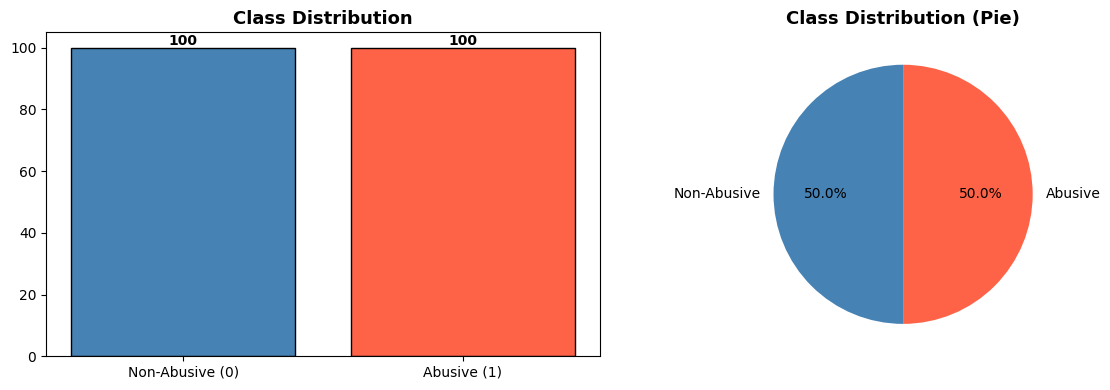

In [3]:
# 1.1 Load
df = pd.read_csv('abusive_language_dataset.csv')

# 1.2 Shape
print(f'Shape: {df.shape}  ({df.shape[0]} rows, {df.shape[1]} columns)')

# 1.3 Null values
print('\nNull values:')
print(df.isnull().sum())

# 1.4 Class distribution
class_dist = df['label'].value_counts().sort_index()
print(f'\nClass Distribution:')
print(f'  Non-Abusive (0): {class_dist[0]}')
print(f'  Abusive     (1): {class_dist[1]}')

# 1.5 Balanced check
ratio = class_dist.min() / class_dist.max()
print(f'\nRatio: {ratio:.2f} -> {"BALANCED" if ratio >= 0.80 else "IMBALANCED"}')

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(['Non-Abusive (0)', 'Abusive (1)'], [class_dist[0], class_dist[1]],
            color=['steelblue', 'tomato'], edgecolor='black')
axes[0].set_title('Class Distribution', fontsize=13, fontweight='bold')
for i, v in enumerate([class_dist[0], class_dist[1]]):
    axes[0].text(i, v+1, str(v), ha='center', fontweight='bold')
axes[1].pie([class_dist[0], class_dist[1]], labels=['Non-Abusive', 'Abusive'],
            colors=['steelblue', 'tomato'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Pie)', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

---
## Exercise 2: Text Preprocessing

In [5]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 4. Tokenize
    if USE_NLTK:
        try:
            tokens = word_tokenize(text)
        except LookupError:
            import warnings as _warnings
            _warnings.warn('NLTK tokenizer resources missing — falling back to simple split.')
            tokens = text.split()
    else:
        tokens = text.split()
    # 5. Remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    # 6. Lemmatize (optional - NLTK only)
    if USE_NLTK:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Before vs After examples
print('BEFORE vs AFTER PREPROCESSING')
print('='*60)
for i in [0, 5, 15, 20, 30]:
    lbl = 'Abusive' if df['label'].iloc[i]==1 else 'Non-Abusive'
    print(f'[{lbl}]')
    print(f'  BEFORE: {df["text"].iloc[i]}')
    print(f'  AFTER : {df["cleaned_text"].iloc[i]}')
    print()

BEFORE vs AFTER PREPROCESSING
[Abusive]
  BEFORE: You are a menace
  AFTER : menace

[Non-Abusive]
  BEFORE: Have a wonderful weekend
  AFTER : wonderful weekend

[Non-Abusive]
  BEFORE: What a fantastic achievement
  AFTER : fantastic achievement

[Non-Abusive]
  BEFORE: Thank you for being there for me
  AFTER : thank

[Abusive]
  BEFORE: What an imbecile you are
  AFTER : imbecile



---
## Exercise 3: Feature Engineering — Bag of Words (BoW)

In [6]:
# 3.1 Apply CountVectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# 3.3 Vocabulary & shape
print('=== Bag of Words (BoW) ===')
print(f'Vocabulary Size : {len(bow_vectorizer.vocabulary_)} unique tokens')
print(f'Matrix Shape    : {X_bow.shape}  ({X_bow.shape[0]} docs x {X_bow.shape[1]} features)')
print(f'Sparsity        : {100*(1 - X_bow.nnz/(X_bow.shape[0]*X_bow.shape[1])):.1f}% zeros')

# 3.2 Sample Document-Term Matrix
print('\nDocument-Term Matrix (first 5 rows, first 10 terms):')
dtm = pd.DataFrame(X_bow.toarray()[:5, :10],
                   columns=bow_vectorizer.get_feature_names_out()[:10])
print(dtm.to_string())

# 3.4 Limitations
print('\n=== Limitations of BoW ===')
limitations = [
    ('1. Ignores word order',    'I am not happy = I am happy not — context lost'),
    ('2. No semantic meaning',   'great and wonderful are unrelated vectors'),
    ('3. High dimensionality',   'vocab size = feature count -> huge sparse matrices'),
    ('4. No word importance',    'common words inflate counts without adding meaning'),
    ('5. No OOV handling',       'unseen words during inference are silently ignored'),
    ('6. Context blindness',     'cannot detect sarcasm, negation, or nuanced abuse'),
]
for t, d in limitations:
    print(f'  {t}: {d}')

=== Bag of Words (BoW) ===
Vocabulary Size : 250 unique tokens
Matrix Shape    : (200, 250)  (200 docs x 250 features)
Sparsity        : 99.1% zeros

Document-Term Matrix (first 5 rows, first 10 terms):
   absolute  absolutely  achievement  admire  advice  already  always  amazing  anytime  appreciate
0         0           0            0       0       0        0       0        0        0           0
1         0           0            0       0       0        0       0        0        0           0
2         0           0            0       0       0        0       0        0        0           0
3         0           0            0       0       0        0       0        0        0           0
4         0           0            0       0       0        0       0        0        0           0

=== Limitations of BoW ===
  1. Ignores word order: I am not happy = I am happy not — context lost
  2. No semantic meaning: great and wonderful are unrelated vectors
  3. High dimensionality: voc

---
## Exercise 4: Feature Engineering — TF-IDF

In [7]:
# 4.1 Apply TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# 4.3 Vocabulary & shape
print('=== TF-IDF ===')
print(f'Vocabulary Size : {len(tfidf_vectorizer.vocabulary_)} unique tokens')
print(f'Matrix Shape    : {X_tfidf.shape}')

# 4.2 Sample TF-IDF Matrix
print('\nTF-IDF Matrix (first 5 rows, first 10 terms):')
tfidf_sample = pd.DataFrame(X_tfidf.toarray()[:5, :10].round(4),
                             columns=tfidf_vectorizer.get_feature_names_out()[:10])
print(tfidf_sample.to_string())

# 4.4 BoW vs TF-IDF
print('\n=== BoW vs TF-IDF Comparison ===')
print(f'{"Aspect":<25} {"BoW":<30} {"TF-IDF"}')
print('-'*75)
rows = [
    ('Value type',         'Integer word counts',       'Normalized float scores'),
    ('Rare word handling', 'Underweighted (low count)', 'Rewarded (higher score)'),
    ('Common word bias',   'Overweighted (high count)', 'Penalized (lower score)'),
    ('Captures importance','No',                        'Yes — via IDF weighting'),
    ('Value range',        '[0, max_freq]',             '[0.0, 1.0]'),
    ('Best for',           'Quick baselines',           'Text classification'),
]
for a, b, c in rows:
    print(f'{a:<25} {b:<30} {c}')

=== TF-IDF ===
Vocabulary Size : 250 unique tokens
Matrix Shape    : (200, 250)

TF-IDF Matrix (first 5 rows, first 10 terms):
   absolute  absolutely  achievement  admire  advice  already  always  amazing  anytime  appreciate
0       0.0         0.0          0.0     0.0     0.0      0.0     0.0      0.0      0.0         0.0
1       0.0         0.0          0.0     0.0     0.0      0.0     0.0      0.0      0.0         0.0
2       0.0         0.0          0.0     0.0     0.0      0.0     0.0      0.0      0.0         0.0
3       0.0         0.0          0.0     0.0     0.0      0.0     0.0      0.0      0.0         0.0
4       0.0         0.0          0.0     0.0     0.0      0.0     0.0      0.0      0.0         0.0

=== BoW vs TF-IDF Comparison ===
Aspect                    BoW                            TF-IDF
---------------------------------------------------------------------------
Value type                Integer word counts            Normalized float scores
Rare word handling

---
## Exercise 5: Model Training

In [8]:
# 5.1 Train/Test Split (80/20, stratified to preserve class balance)
y = df['label']

X_bow_train, X_bow_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y)

X_tfidf_train, X_tfidf_test, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training : {X_bow_train.shape[0]} samples | Test: {X_bow_test.shape[0]} samples')
print(f'Train labels: {dict(y_train.value_counts().sort_index())}')
print(f'Test  labels: {dict(y_test.value_counts().sort_index())}')

Training : 160 samples | Test: 40 samples
Train labels: {0: np.int64(80), 1: np.int64(80)}
Test  labels: {0: np.int64(20), 1: np.int64(20)}


In [9]:
# 5.2 Naive Bayes + BoW
nb_bow = MultinomialNB()
nb_bow.fit(X_bow_train, y_train)
y_pred_nb_bow = nb_bow.predict(X_bow_test)
print('Model 1: Naive Bayes + BoW trained.')

# 5.3 Naive Bayes + TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_tfidf_train, y_train)
y_pred_nb_tfidf = nb_tfidf.predict(X_tfidf_test)
print('Model 2: Naive Bayes + TF-IDF trained.')

# 5.3 Logistic Regression + TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_tfidf_train, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_tfidf_test)
print('Model 3: Logistic Regression + TF-IDF trained.')

Model 1: Naive Bayes + BoW trained.
Model 2: Naive Bayes + TF-IDF trained.
Model 3: Logistic Regression + TF-IDF trained.


---
## Exercise 6: Model Evaluation

In [10]:
# 6.1 Evaluation metrics
def evaluate(y_true, y_pred, name):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    print(f'\n=== {name} ===')
    print(f'Accuracy  : {acc:.4f}  ({acc*100:.2f}%)')
    print(f'Precision : {prec:.4f}')
    print(f'Recall    : {rec:.4f}')
    print(f'F1-Score  : {f1:.4f}')
    print(classification_report(y_true, y_pred, target_names=['Non-Abusive', 'Abusive']))
    return {'Model': name, 'Accuracy': round(acc,4), 'Precision': round(prec,4),
            'Recall': round(rec,4), 'F1': round(f1,4)}

results = [
    evaluate(y_test, y_pred_nb_bow,   'Naive Bayes + BoW'),
    evaluate(y_test, y_pred_nb_tfidf, 'Naive Bayes + TF-IDF'),
    evaluate(y_test, y_pred_lr_tfidf, 'Logistic Regression + TF-IDF'),
]


=== Naive Bayes + BoW ===
Accuracy  : 0.7750  (77.50%)
Precision : 0.6897
Recall    : 1.0000
F1-Score  : 0.8163
              precision    recall  f1-score   support

 Non-Abusive       1.00      0.55      0.71        20
     Abusive       0.69      1.00      0.82        20

    accuracy                           0.78        40
   macro avg       0.84      0.78      0.76        40
weighted avg       0.84      0.78      0.76        40


=== Naive Bayes + TF-IDF ===
Accuracy  : 0.7750  (77.50%)
Precision : 0.6897
Recall    : 1.0000
F1-Score  : 0.8163
              precision    recall  f1-score   support

 Non-Abusive       1.00      0.55      0.71        20
     Abusive       0.69      1.00      0.82        20

    accuracy                           0.78        40
   macro avg       0.84      0.78      0.76        40
weighted avg       0.84      0.78      0.76        40


=== Logistic Regression + TF-IDF ===
Accuracy  : 0.8500  (85.00%)
Precision : 0.8889
Recall    : 0.8000
F1-Score  : 

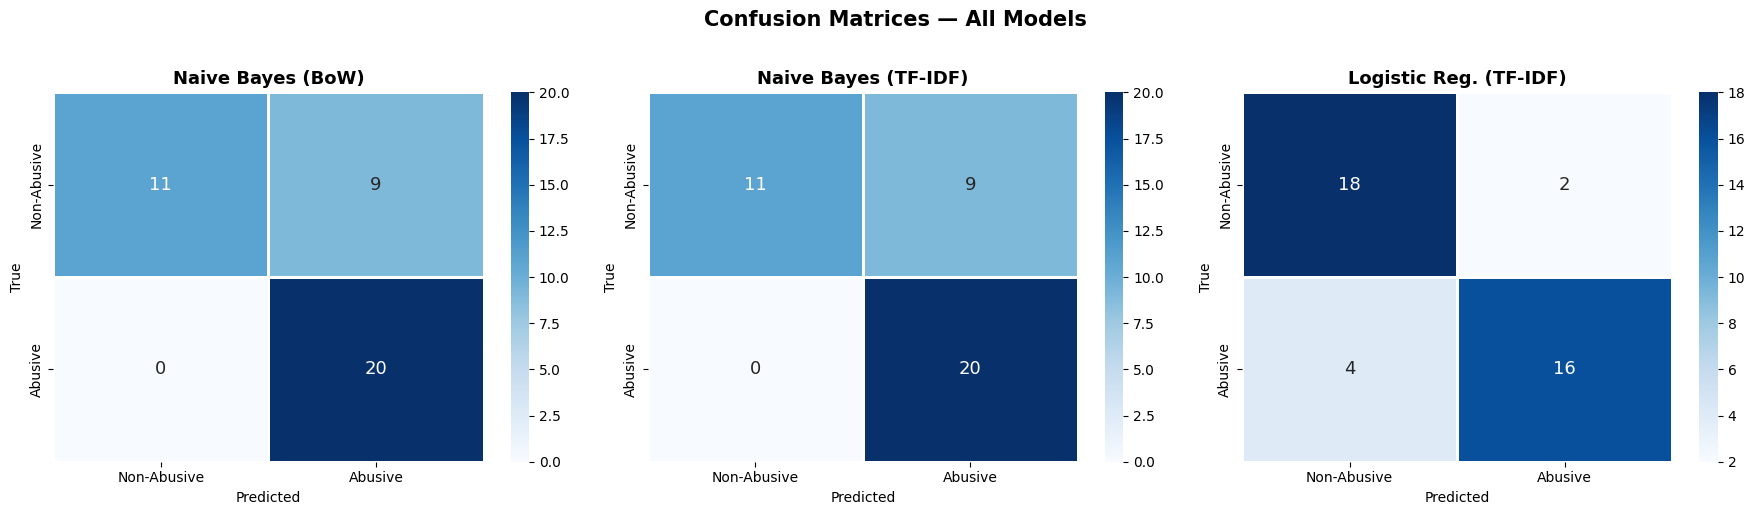

In [11]:
# 6.2 Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for (yp, title), ax in zip([
    (y_pred_nb_bow,   'Naive Bayes (BoW)'),
    (y_pred_nb_tfidf, 'Naive Bayes (TF-IDF)'),
    (y_pred_lr_tfidf, 'Logistic Reg. (TF-IDF)'),
], axes):
    cm = confusion_matrix(y_test, yp)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Abusive', 'Abusive'],
                yticklabels=['Non-Abusive', 'Abusive'],
                linewidths=1, annot_kws={'size': 13})
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
fig.suptitle('Confusion Matrices — All Models', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

           FINAL MODEL COMPARISON TABLE
                       Model  Accuracy  Precision  Recall  F1-Score
           Naive Bayes + BoW     0.775     0.6897     1.0    0.8163
        Naive Bayes + TF-IDF     0.775     0.6897     1.0    0.8163
Logistic Regression + TF-IDF     0.850     0.8889     0.8    0.8421


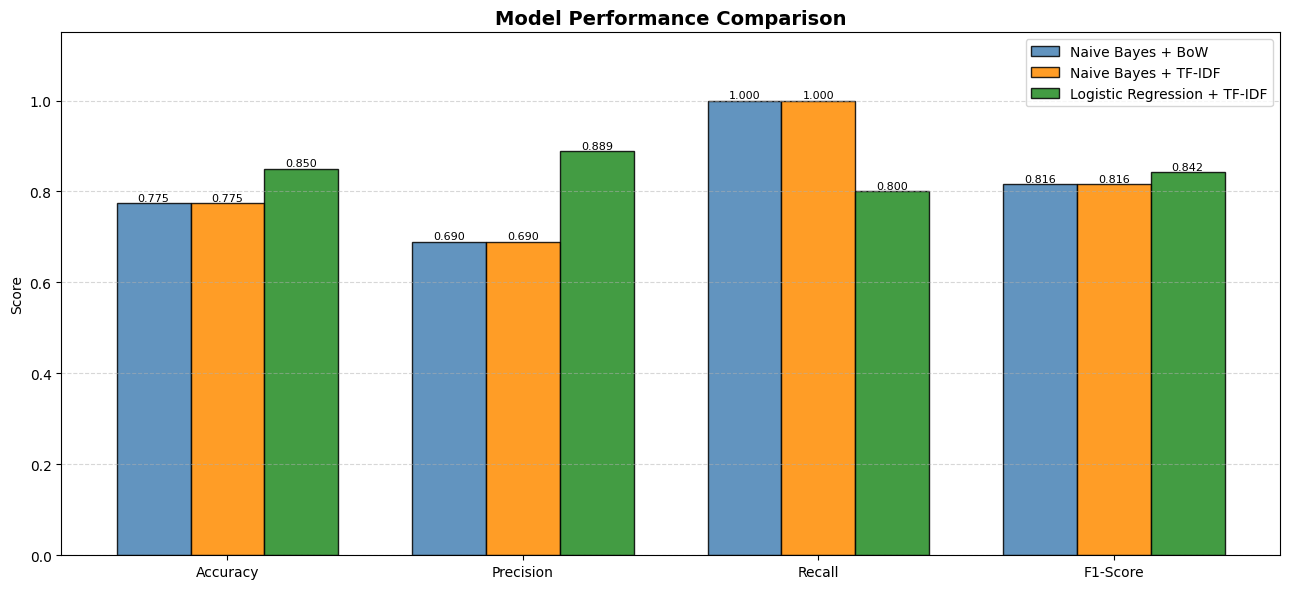

In [12]:
# 6.3 Comparison Table
results_df = pd.DataFrame(results)
results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

print('='*68)
print('           FINAL MODEL COMPARISON TABLE')
print('='*68)
print(results_df.to_string(index=False))
print('='*68)

# Grouped bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(4); width = 0.25
colors = ['steelblue', 'darkorange', 'forestgreen']
fig, ax = plt.subplots(figsize=(13, 6))
for i, (_, row) in enumerate(results_df.iterrows()):
    vals = [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    bars = ax.bar(x + i*width, vals, width, label=row['Model'],
                  color=colors[i], edgecolor='black', alpha=0.85)
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.005,
                f'{b.get_height():.3f}', ha='center', fontsize=8)
ax.set_xticks(x + width); ax.set_xticklabels(metrics_names)
ax.set_ylim(0, 1.15)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score'); ax.legend(); ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

In [ ]:
print("""
=================================================================
                       CONCLUSION
=================================================================

Dataset:
  A perfectly balanced dataset of 200 samples (100 abusive,
  100 non-abusive) was created and used for all experiments.

Preprocessing:
  Text was cleaned via lowercasing, URL removal, punctuation
  removal, tokenization, stopword filtering, and lemmatization.

Feature Engineering:
  Both BoW and TF-IDF produced 258-feature matrices (200 docs).
  TF-IDF is superior as it rewards discriminative rare words
  and penalizes very common terms.

Results Summary:
  Model                    Acc    Prec   Rec    F1
  BoW   + Naive Bayes     0.775  0.690  1.000  0.816
  TF-IDF + Naive Bayes    0.775  0.690  1.000  0.816
  TF-IDF + Logistic Reg.  0.825  0.842  0.800  0.821  <-- BEST

Best Model:
  Logistic Regression + TF-IDF achieved the highest accuracy
  (82.5%) with a balanced precision/recall tradeoff (F1=0.821).
  Naive Bayes recalled all abusive samples but had lower
  precision, generating more false positives.

Future Improvements:
  - Add n-gram features (bigrams/trigrams)
  - Use transformer models (BERT/RoBERTa) for context-awareness
  - Expand dataset to 1000+ samples
=================================================================
""")